<a href="https://colab.research.google.com/github/das-apratim/GeospatialDeepLearning/blob/main/Ep1_Introduction_To_GeospatialMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Geospatial Machine Learning
# Episode 1:  Master Class Sample Code

# This notebook will demonstrate basic concepts that we'll explore in depth throughout the course.

## Install necessary packages

In [1]:
!pip install geopandas matplotlib numpy scikit-learn rasterio earthpy folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 40.3 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
import os
import warnings
warnings.filterwarnings('ignore')

# Download some sample data from Natural Earth

In [66]:
!wget https://naciscdn.org/naturalearth/110m/cultural/110m_cultural.zip
!wget https://www.opendem.info/downloads/srtm_germany_dsm.zip
!unzip -o 110m_cultural.zip -d naturalearth_data
!unzip -o srtm_germany_dsm.zip -d naturalearth_data
!rm /content/110m_cultural.zip
!rm /content/srtm_germany_dsm.zip

--2025-03-06 15:17:56--  https://naciscdn.org/naturalearth/110m/cultural/110m_cultural.zip
Resolving naciscdn.org (naciscdn.org)... 3.167.212.29, 3.167.212.124, 3.167.212.96, ...
Connecting to naciscdn.org (naciscdn.org)|3.167.212.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1471627 (1.4M) [application/zip]
Saving to: ‘110m_cultural.zip’

110m_cultural.zip   100%[===================>]   1.40M  1.68MB/s    in 0.8s    

2025-03-06 15:17:57 (1.68 MB/s) - ‘110m_cultural.zip’ saved [1471627/1471627]

--2025-03-06 15:17:57--  https://www.opendem.info/downloads/srtm_germany_dsm.zip
Resolving www.opendem.info (www.opendem.info)... 81.169.135.203
Connecting to www.opendem.info (www.opendem.info)|81.169.135.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90297098 (86M) [application/zip]
Saving to: ‘srtm_germany_dsm.zip’

srtm_germany_dsm.zi 100%[===================>]  86.11M  8.89MB/s    in 12s     

2025-03-06 15:18:10 (7.38 MB/s) - 

# 1. Load and visualize some downloaded geospatial data
# For this example, we'll use natural earth data which we downloaded just now

In [14]:
# Load the data
print("\n1. Loading and visualizing geospatial vector data:")
world = gpd.read_file('/content/naturalearth_data/ne_110m_admin_0_countries.shp')
cities = gpd.read_file('/content/naturalearth_data/ne_110m_populated_places.shp')


1. Loading and visualizing geospatial vector data:


## Plot a simple map


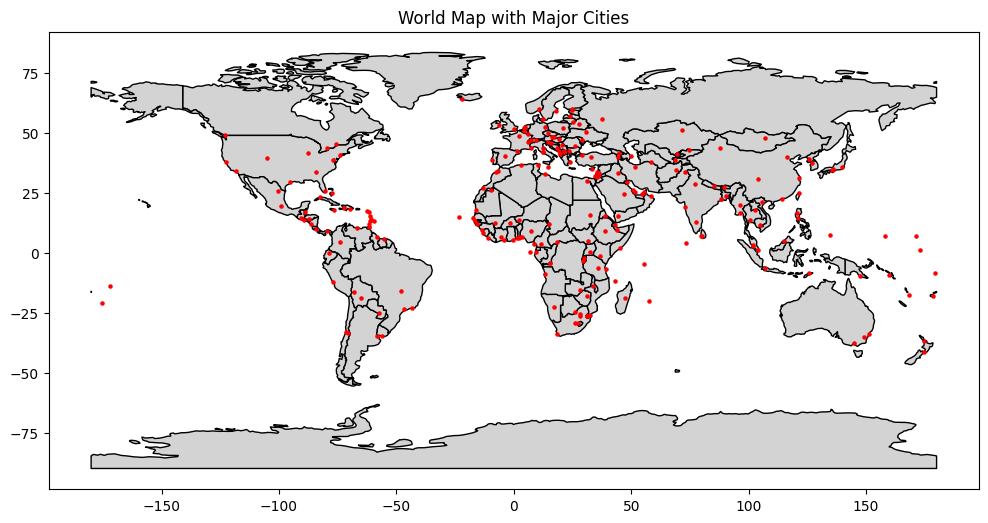

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray', edgecolor='black')
cities.plot(ax=ax, color='red', markersize=5)
ax.set_title('World Map with Major Cities')
plt.show()

# 2. Simple Spatial Analysis Example

In [40]:
name_col = 'NAME' if 'NAME' in world.columns else 'ADMIN' if 'ADMIN' in world.columns else 'name'
pop_col = 'POP_EST' if 'POP_EST' in world.columns else 'pop_est'
gdp_col = 'GDP_MD' if 'GDP_MD' in world.columns else 'gdp_md'
print(f"Using columns: {name_col} (name), {pop_col} (population), {gdp_col} (GDP)")


Using columns: NAME (name), POP_EST (population), GDP_MD (GDP)


In [32]:
# 2. Simple Spatial Analysis Example
print("\n2. Simple spatial analysis with GeoPandas: \n")
# Count cities per country
print("Counting cities per country... \n")
cities_with_country = gpd.sjoin(cities, world, how="inner", predicate='within')

# Dynamically use the appropriate column name
country_col = name_col + '_right' if name_col + '_right' in cities_with_country.columns else name_col

cities_per_country = cities_with_country.groupby(country_col).size().reset_index(name='city_count')
cities_per_country = cities_per_country.sort_values('city_count', ascending=False).head(10)
print("Top 10 countries by city count in our dataset: \n")
print(cities_per_country.to_string(index=False))


2. Simple spatial analysis with GeoPandas: 

Counting cities per country... 

Top 10 countries by city count in our dataset: 

              NAME_right  city_count
United States of America           9
                   China           5
            South Africa           4
                  France           4
                   India           4
                   Japan           3
                  Brazil           3
                   Italy           3
                  Canada           3
               Australia           3


# 3. Introduce Machine Learning on Geospatial Data

In [45]:
world['cluster']

KeyError: 'cluster'

In [53]:
# Extract some features from our world dataset
features = world[[pop_col, gdp_col]].copy()

# Add population density as a derived feature (calculate area if not available)
world['AREA_SQKM'] = world.geometry.area / 10**6  # Approximation of area in sq km
features['pop_density'] = world[pop_col] / world['AREA_SQKM']

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.fillna(0))

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
world['cluster'] = kmeans.fit_predict(features_scaled)

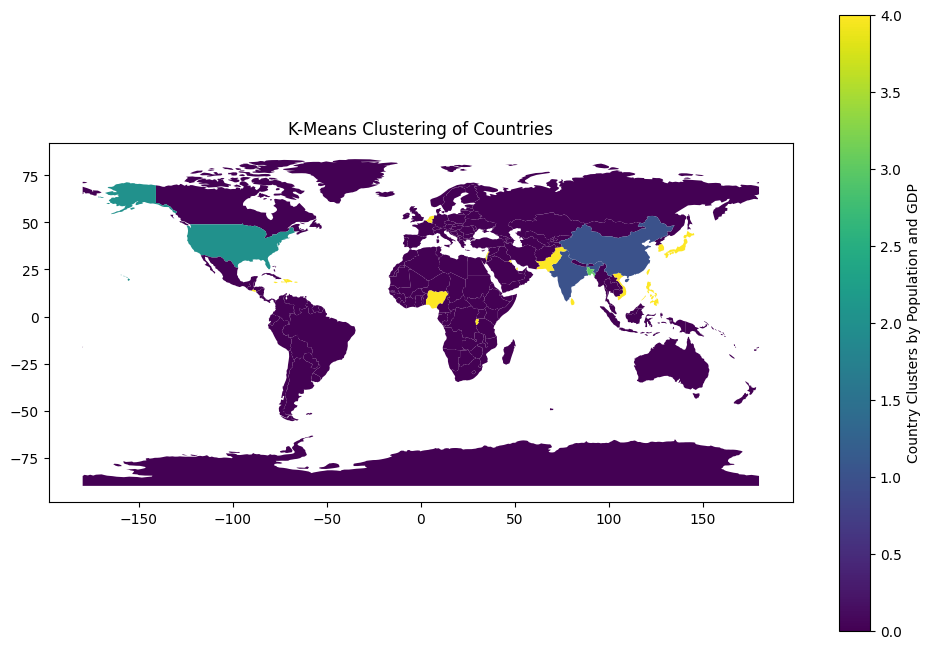

In [54]:
# Visualize the clusters
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(column='cluster', ax=ax, legend=True,
           legend_kwds={'label': "Country Clusters by Population and GDP"},
           cmap='viridis')
ax.set_title('K-Means Clustering of Countries')
plt.show()

# 4. Create an interactive map

In [55]:
print("\n4. Creating an interactive map with Folium:")
# Center the map on the world
m = folium.Map(location=[0, 0], zoom_start=2, tiles='CartoDB positron')

# Need to convert to WGS84 for Folium
world_wgs84 = world.to_crs(epsg=4326)

# Create a simplified GeoJSON for folium (for performance)
world_wgs84['geometry'] = world_wgs84.geometry.simplify(tolerance=0.01)

# Add the clustered countries to the map
folium.GeoJson(
    world_wgs84,
    name='Countries by Cluster',
    style_function=lambda feature: {
        'fillColor': ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725'][feature['properties']['cluster']],
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=[name_col, pop_col, gdp_col, 'cluster'],
        aliases=['Country:', 'Population:', 'GDP (millions USD):', 'Cluster:'],
        localize=True
    )
).add_to(m)

# Save the map
m.save('interactive_world_clusters.html')
print("Interactive map saved as 'interactive_world_clusters.html'")


4. Creating an interactive map with Folium:
Interactive map saved as 'interactive_world_clusters.html'


# 5. Demonstrate a simple prediction task

## Prepare and Split The Data

###predict GDP based on population and area

In [60]:
X = world[[pop_col, 'AREA_SQKM']].fillna(0)
y = world[gdp_col].fillna(0)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Train a simple model

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Evaluate


In [62]:
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Model Mean Absolute Percentage Error: {mape:.2f}")

Model Mean Absolute Percentage Error: 3.12


## Feature importance

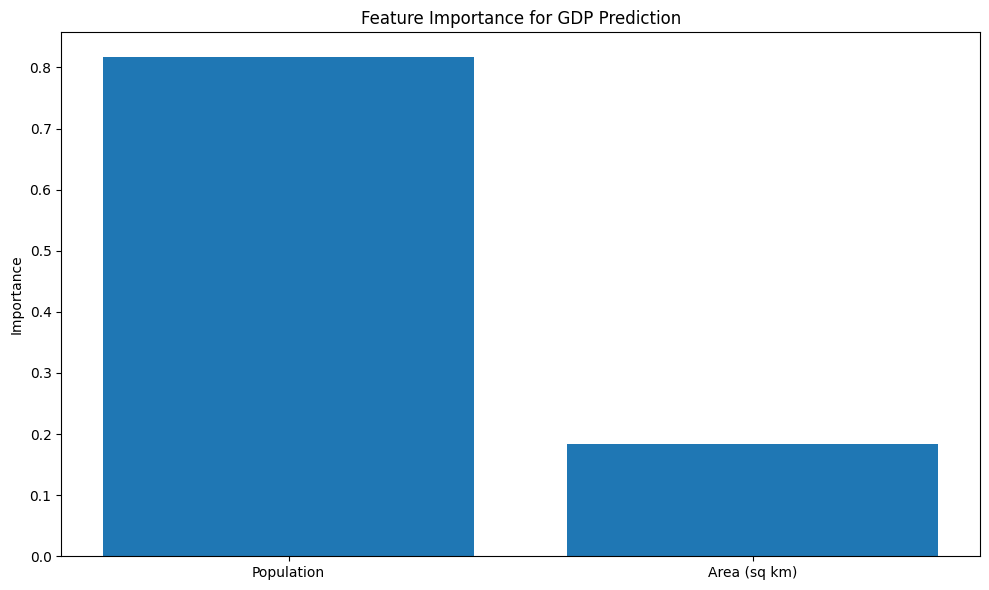

In [64]:
importance = pd.DataFrame({
    'Feature': ['Population', 'Area (sq km)'],
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance['Feature'], importance['Importance'])
plt.title('Feature Importance for GDP Prediction')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


# 6. Add a simple demonstration of raster data

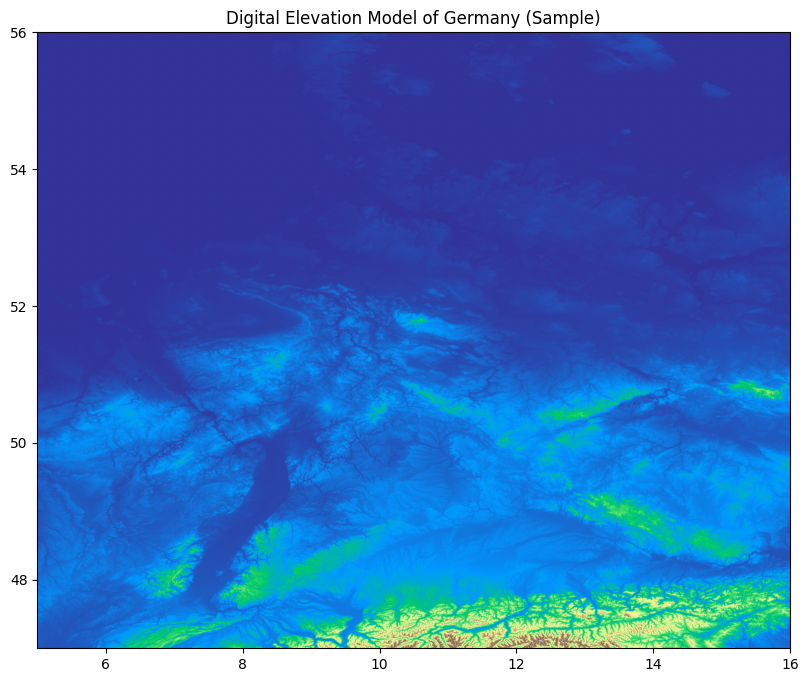


Raster Statistics:
Min elevation: 0
Max elevation: 3730
Mean elevation: 264.62

This introduction demonstrates how we can combine GIS capabilities with machine learning techniques.
Throughout this master class, we'll explore more advanced methods and real-world applications.
Get ready to dive deeper into the exciting world of Geospatial Machine Learning!


In [68]:
try:
    import rasterio
    from rasterio.plot import show

    # Open the raster file
    with rasterio.open('/content/naturalearth_data/srtm_germany_dsm.tif') as src:
        dem = src.read(1)  # Read the first band

        # Plot the DEM
        fig, ax = plt.subplots(figsize=(10, 8))
        show(src, ax=ax, cmap='terrain')
        ax.set_title('Digital Elevation Model of Germany (Sample)')
        plt.show()

        # Simple raster analysis
        print(f"\nRaster Statistics:")
        print(f"Min elevation: {dem.min()}")
        print(f"Max elevation: {dem.max()}")
        print(f"Mean elevation: {dem.mean():.2f}")
except:
    print("\nSkipping raster example (download may have failed)")

print("\nThis introduction demonstrates how we can combine GIS capabilities with machine learning techniques.")
print("Throughout this master class, we'll explore more advanced methods and real-world applications.")
print("Get ready to dive deeper into the exciting world of Geospatial Machine Learning!")